In [1]:
cd ../../

/workspaces/research/motor-decoding


In [2]:
import json
import os
import sys
from collections import Counter
from itertools import cycle
from pathlib import Path

import dabest
import matplotlib.pyplot as plt
import seaborn as sns
import mne
import numpy as np
import pandas as pd

from mne.time_frequency import tfr_morlet, psd_multitaper, psd_welch
from mne_bids import BIDSPath
from mne_bids.read import read_raw_bids
from mne_bids.tsv_handler import _from_tsv
from rerf.rerfClassifier import rerfClassifier
from scipy.io import loadmat
from scipy.spatial.distance import euclidean
from scipy import stats
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, accuracy_score, plot_confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, TimeSeriesSplit
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler, LabelBinarizer, label_binarize
from tqdm import tqdm

from mtsmorf.io.read import read_dataset, read_label, read_trial, get_trial_info, _get_bad_chs
from mtsmorf.io.utils import NumpyEncoder
from mtsmorf.war_exp.cv import nested_cv_fit, cv_fit, bootstrap_fit


from mtsmorf.move_exp.plotting import (
    plot_signals,
    plot_roc_multiclass_cv,
    plot_feature_importances,
    plot_cv_indices
)

# plt.style.use(['science', 'ieee', 'no-latex'])

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
# bids_root = Path("/Users/ChesterHuynh/OneDrive - Johns Hopkins/research/data/efri/")

tmin, tmax = (-0.75, 1.25)

bids_root = Path("/workspaces/research/mnt/data/efri")
derivatives_path = (
    bids_root / "derivatives" / "preprocessed" / f"tmin={tmin}-tmax={tmax}" / "low-pass=1000Hz-downsample=500"
)

# subject identifiers
subject = "efri26"
session = "efri"
task = "move"
acquisition = "seeg"
run = "01"
kind = "ieeg"

bids_path = BIDSPath(subject=subject, session=session, task=task,
                     acquisition=acquisition, run=run, suffix=kind, extension=".vhdr", root=bids_root)

In [4]:
# fetch labels
labels, trial_ids = read_label(bids_path, trial_id=None, label_keyword="target_direction")

# we don't want perturbed trials
behav_tsv, events_tsv = get_trial_info(bids_path)
success_trial_flag = np.array(list(map(int, behav_tsv["successful_trial_flag"])))
success_inds = np.where(success_trial_flag == 1)[0]
force_mag = np.array(behav_tsv['force_magnitude'], np.float64)[success_inds]

# filter out labels for unsuccessful trials
unsuccessful_trial_inds = np.where((np.isnan(labels) | (force_mag > 0)))[0]
labels = np.delete(labels, unsuccessful_trial_inds)

Out of 129 trials, there were 124 successful trials in /workspaces/research/mnt/data/efri/sub-efri26/ses-efri/ieeg/sub-efri26_ses-efri_task-move_acq-seeg_run-01_ieeg.vhdr.
Out of 129 trials, there were 124 successful trials in /workspaces/research/mnt/data/efri/sub-efri26/ses-efri/ieeg/sub-efri26_ses-efri_task-move_acq-seeg_run-01_ieeg.vhdr.


## Computing Spectral Power for 70-200Hz
- Tried training only on median frequency bin (performs near chance)
- Likely because we dropped a great deal of spectral content

In [6]:
# get preprocessed epochs data
fname = os.path.splitext(bids_path.basename)[0] + "-epo.fif"
fpath = derivatives_path / subject / fname

epochs = mne.read_epochs(fpath, preload=True)
epochs = epochs.drop(unsuccessful_trial_inds)

Reading /workspaces/research/mnt/data/efri/derivatives/preprocessed/tmin=-0.75-tmax=1.25/low-pass=1000Hz-downsample=500/efri26/sub-efri26_ses-efri_task-move_acq-seeg_run-01_ieeg-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =    -750.00 ...    1248.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
124 matching events found
No baseline correction applied
0 projection items activated
Dropped 30 epochs: 9, 15, 20, 22, 25, 26, 31, 35, 48, 50, 54, 56, 59, 62, 64, 65, 66, 70, 79, 86, 88, 100, 105, 109, 110, 112, 115, 117, 119, 122


In [7]:
nfreqs = 10
freqs = np.logspace(*np.log10([70, 200]), num=nfreqs)
n_cycles = freqs / 2.  # different number of cycle per frequency
power = tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, average=False,
                   return_itc=False, decim=3, n_jobs=1)

hi_gamma = power.data
hi_gamma.shape

Not setting metadata


(94, 106, 10, 334)

No baseline correction applied
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


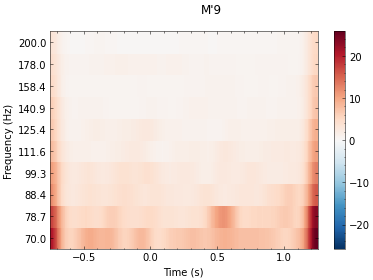

In [8]:
power.average().plot([0]);

## Average across freqs

In [9]:
avg_freq_data = np.mean(hi_gamma, axis=2)

# Trim time window
times = np.where((power.times >= -0.5) & (power.times <= 1.0))[0]
avg_freq_data = avg_freq_data[:, :, times]

print(avg_freq_data.shape)

rng = 1

included_trials = np.isin(labels, [0, 1, 2, 3])

# Create X, y data
X = avg_freq_data[included_trials].reshape(np.sum(included_trials), -1)
y = labels[included_trials]

(94, 106, 250)


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


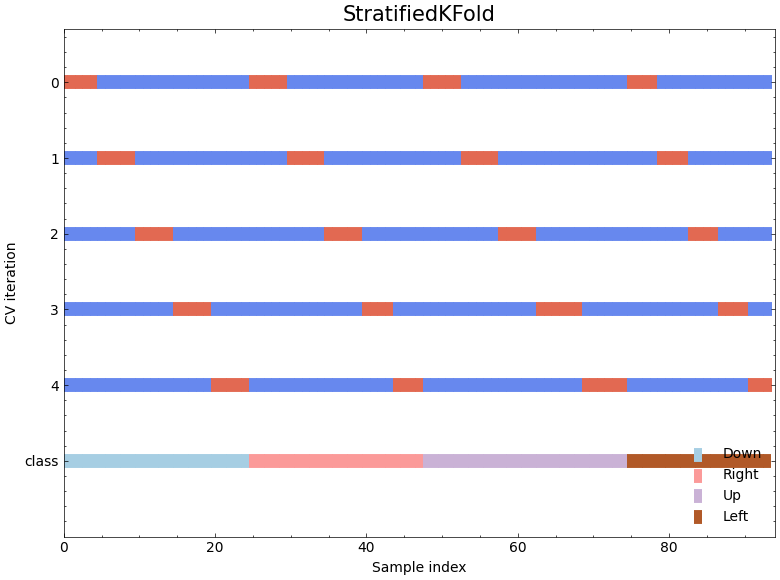

In [13]:
# Perform K-Fold cross validation
n_splits = 5
cv = StratifiedKFold(n_splits=n_splits, shuffle=False)

fig, ax = plt.subplots(dpi=100, figsize=(8, 6))
argsort_inds = np.argsort(y)
plot_cv_indices(cv, X[argsort_inds], y[argsort_inds], ax, n_splits, lw=10)
ax.legend(loc='lower right')
fig.tight_layout();

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


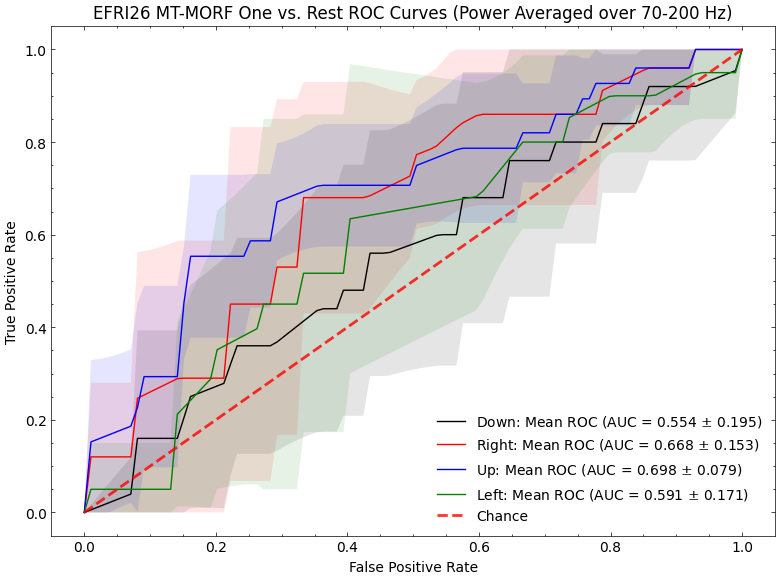

In [11]:
metrics = [
    # 'f1_micro',
    # 'f1_macro',
    'accuracy',
    'roc_auc_ovr',
]

mtsmorf = rerfClassifier(
    projection_matrix="MT-MORF",
    max_features="auto",
    n_jobs=-1,
    random_state=rng,
    image_height=avg_freq_data.shape[1],
    image_width=avg_freq_data.shape[2],
)

# Cross validation. Fit model
stratified_kf_scores_freq_avg = cv_fit(mtsmorf, X, y, metrics=metrics, cv=cv, n_jobs=None, return_train_score=True, return_estimator=True)

# Plot results
fig, ax = plt.subplots(dpi=100, figsize=(8, 6))

plot_roc_multiclass_cv(
    stratified_kf_scores_freq_avg["test_predict_proba"],
    X,
    y,
    stratified_kf_scores_freq_avg["test_inds"],
    ax=ax,
)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title=f"{subject.upper()} MT-MORF One vs. Rest ROC Curves (Power Averaged over 70-200 Hz)",
)
ax.legend(loc="lower right")
fig.tight_layout();

## Increase granularity of freq dimension

In [19]:
nfreqs = 30
freqs = np.logspace(*np.log10([70, 200]), num=nfreqs)
n_cycles = freqs / 2.  # different number of cycle per frequency
power = tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, average=False,
                   return_itc=False, decim=3, n_jobs=1)

Not setting metadata


No baseline correction applied


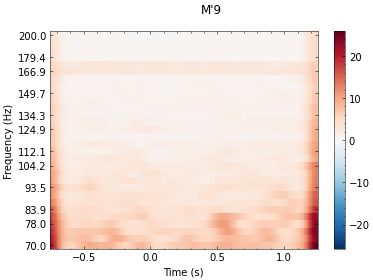

In [20]:
power.average().plot([0]);

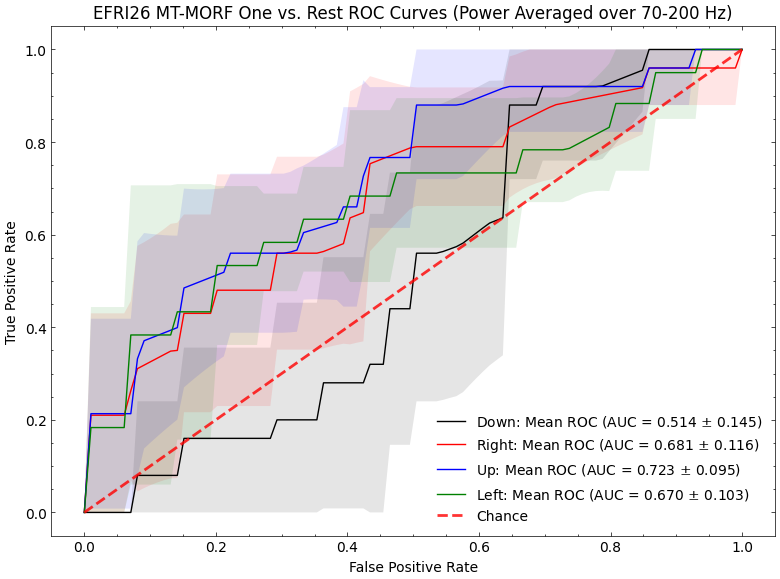

In [22]:
hi_gamma = power.data
avg_freq_data = np.mean(hi_gamma, axis=2)

# Trim time window
times = np.where((power.times >= -0.5) & (power.times <= 1.0))[0]
avg_freq_data = avg_freq_data[:, :, times]

rng = 1

included_trials = np.isin(labels, [0, 1, 2, 3])

# Create X, y data
X = avg_freq_data[included_trials].reshape(np.sum(included_trials), -1)
y = labels[included_trials]

metrics = [
    # 'f1_micro',
    # 'f1_macro',
    'accuracy',
    'roc_auc_ovr',
]

mtsmorf = rerfClassifier(
    projection_matrix="MT-MORF",
    max_features="auto",
    n_jobs=-1,
    random_state=rng,
    image_height=avg_freq_data.shape[1],
    image_width=avg_freq_data.shape[2],
)

stratified_kf_scores_more_freq = cv_fit(mtsmorf, X, y, metrics=metrics, cv=cv, n_jobs=None, return_train_score=True, return_estimator=True)

# Plotting results
fig, ax = plt.subplots(dpi=100, figsize=(8, 6))

plot_roc_multiclass_cv(
    stratified_kf_scores_more_freq["test_predict_proba"],
    X,
    y,
    stratified_kf_scores_more_freq["test_inds"],
    ax=ax,
)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title=f"{subject.upper()} MT-MORF One vs. Rest ROC Curves (Power Averaged over 70-200 Hz)",
)
ax.legend(loc="lower right")
fig.tight_layout();

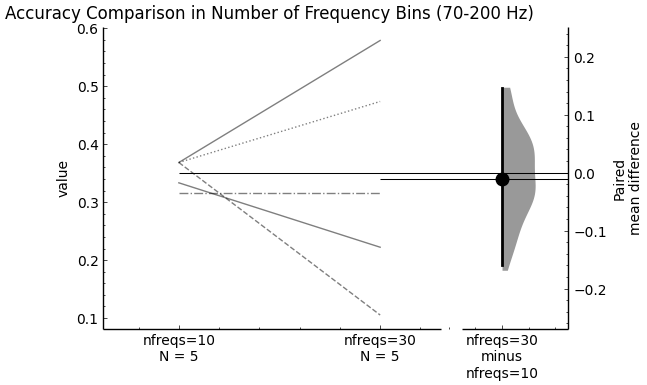

In [23]:
id_col = pd.Series(range(1, n_splits+1))

df = pd.DataFrame({
    "ID": id_col,
    "nfreqs=10": stratified_kf_scores_freq_avg["test_accuracy"],
    "nfreqs=30": stratified_kf_scores_more_freq["test_accuracy"],
})

my_data = dabest.load(df, idx=("nfreqs=10", "nfreqs=30"), 
                      id_col="ID", paired=True, resamples=100, 
                      random_seed=rng)

fig, ax = plt.subplots(dpi=100)

my_data.mean_diff.plot(ax=ax)
ax.set(title="Accuracy Comparison in Number of Frequency Bins (70-200 Hz)");

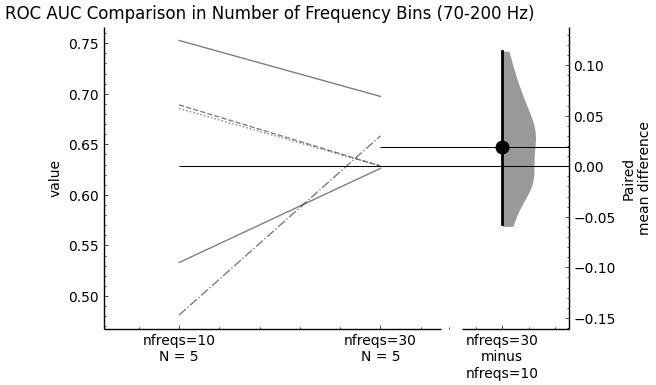

In [24]:
id_col = pd.Series(range(1, n_splits+1))

df = pd.DataFrame({
    "ID": id_col,
    "nfreqs=10": stratified_kf_scores_freq_avg["test_roc_auc_ovr"],
    "nfreqs=30": stratified_kf_scores_more_freq["test_roc_auc_ovr"],
})

my_data = dabest.load(df, idx=("nfreqs=10", "nfreqs=30"), 
                      id_col="ID", paired=True, resamples=100, 
                      random_seed=rng)

fig, ax = plt.subplots(dpi=100)

my_data.mean_diff.plot(ax=ax)
ax.set(title="ROC AUC Comparison in Number of Frequency Bins (70-200 Hz)");

## Shrinking freq range to 70-110 Hz

In [25]:
nfreqs = 10
freqs = np.logspace(*np.log10([70, 110]), num=nfreqs)
n_cycles = freqs / 2.  # different number of cycle per frequency
power = tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, average=False,
                   return_itc=False, decim=3, n_jobs=1)

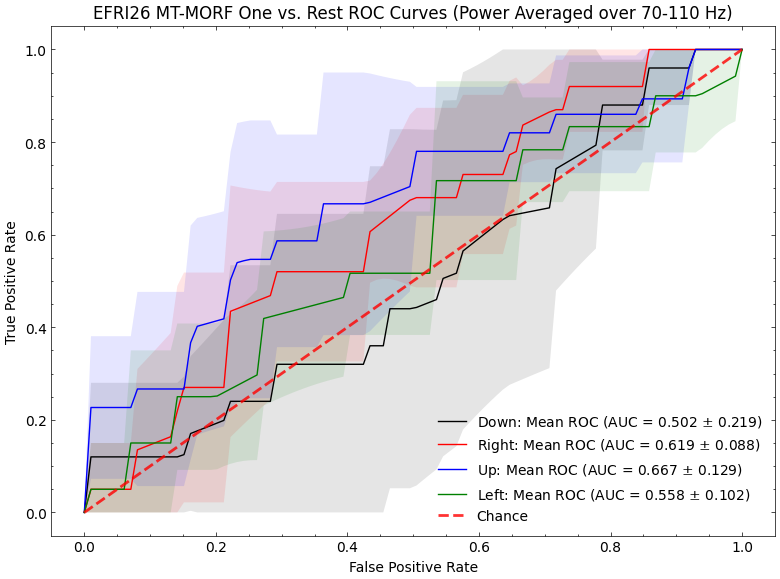

In [26]:
hi_gamma = power.data
avg_freq_data = np.mean(hi_gamma, axis=2)

# Trim time window
times = np.where((power.times >= -0.5) & (power.times <= 1.0))[0]
avg_freq_data = avg_freq_data[:, :, times]

rng = 1

included_trials = np.isin(labels, [0, 1, 2, 3])

# Create X, y data
X = avg_freq_data[included_trials].reshape(np.sum(included_trials), -1)
y = labels[included_trials]

metrics = [
    # 'f1_micro',
    # 'f1_macro',
    'accuracy',
    'roc_auc_ovr',
]

mtsmorf = rerfClassifier(
    projection_matrix="MT-MORF",
    max_features="auto",
    n_jobs=-1,
    random_state=rng,
    image_height=avg_freq_data.shape[1],
    image_width=avg_freq_data.shape[2],
)

stratified_kf_scores_trimmed = cv_fit(mtsmorf, X, y, metrics=metrics, cv=cv, n_jobs=None, return_train_score=True, return_estimator=True)

# Plotting results
fig, ax = plt.subplots(dpi=100, figsize=(8, 6))

plot_roc_multiclass_cv(
    stratified_kf_scores_trimmed["test_predict_proba"],
    X,
    y,
    stratified_kf_scores_trimmed["test_inds"],
    ax=ax,
)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title=f"{subject.upper()} MT-MORF One vs. Rest ROC Curves (Power Averaged over 70-110 Hz)",
)
ax.legend(loc="lower right")
fig.tight_layout();

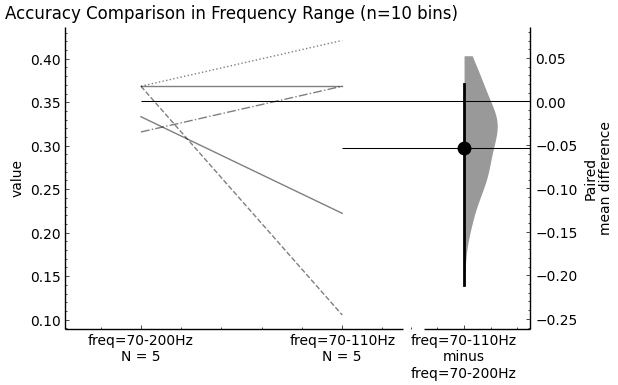

In [27]:
id_col = pd.Series(range(1, n_splits+1))

df = pd.DataFrame({
    "ID": id_col,
    "freq=70-200Hz": stratified_kf_scores_freq_avg["test_accuracy"],
    "freq=70-110Hz": stratified_kf_scores_trimmed["test_accuracy"],
})

my_data = dabest.load(df, idx=("freq=70-200Hz", "freq=70-110Hz"),
                      id_col="ID", paired=True, resamples=100, 
                      random_seed=rng)

fig, ax = plt.subplots(dpi=100)

my_data.mean_diff.plot(ax=ax)
ax.set(title="Accuracy Comparison in Frequency Range (n=10 bins)");

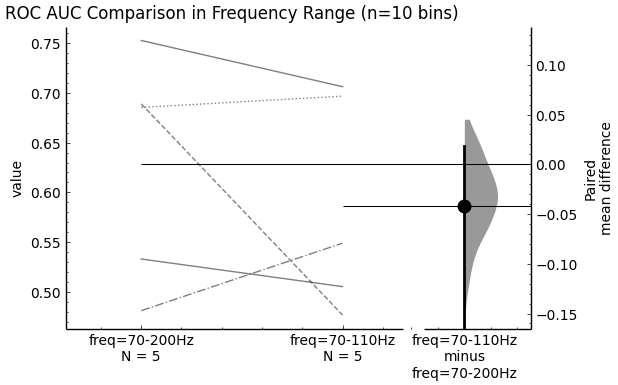

In [28]:
id_col = pd.Series(range(1, n_splits+1))

df = pd.DataFrame({
    "ID": id_col,
    "freq=70-200Hz": stratified_kf_scores_freq_avg["test_roc_auc_ovr"],
    "freq=70-110Hz": stratified_kf_scores_trimmed["test_roc_auc_ovr"],
})

my_data = dabest.load(df, idx=("freq=70-200Hz", "freq=70-110Hz"),
                      id_col="ID", paired=True, resamples=100, 
                      random_seed=rng)

fig, ax = plt.subplots(dpi=100)

my_data.mean_diff.plot(ax=ax)
ax.set(title="ROC AUC Comparison in Frequency Range (n=10 bins)");

## 35-110 Hz

In [32]:
nfreqs = 10
freqs = np.logspace(*np.log10([35, 110]), num=nfreqs)
n_cycles = freqs / 2.  # different number of cycle per frequency
power = tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, average=False,
                   return_itc=False, decim=3, n_jobs=1)

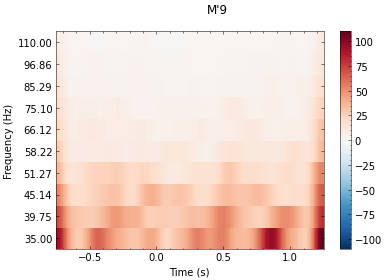

In [37]:
power.average().plot([0]);

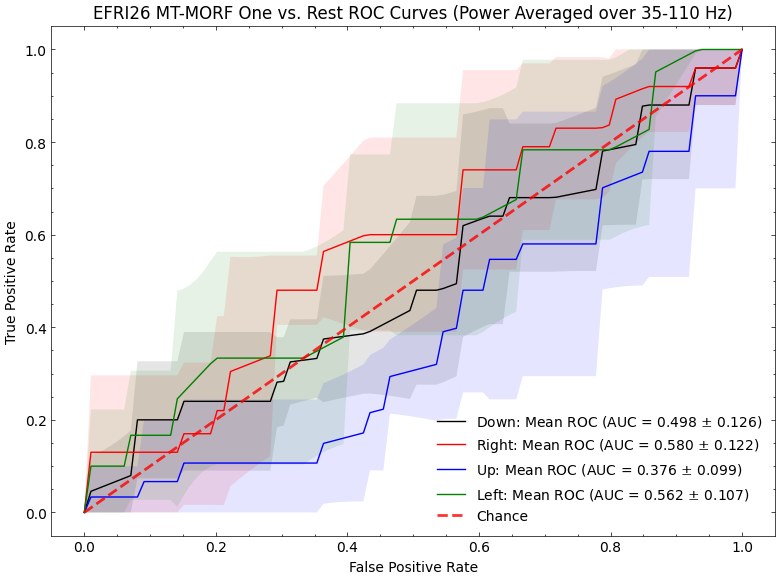

In [38]:
hi_gamma = power.data
avg_freq_data = np.mean(hi_gamma, axis=2)

# Trim time window
times = np.where((power.times >= -0.5) & (power.times <= 1.0))[0]
avg_freq_data = avg_freq_data[:, :, times]

rng = 1

included_trials = np.isin(labels, [0, 1, 2, 3])

# Create X, y data
X = avg_freq_data[included_trials].reshape(np.sum(included_trials), -1)
y = labels[included_trials]

metrics = [
    # 'f1_micro',
    # 'f1_macro',
    'accuracy',
    'roc_auc_ovr',
]

mtsmorf = rerfClassifier(
    projection_matrix="MT-MORF",
    max_features="auto",
    n_jobs=-1,
    random_state=rng,
    image_height=avg_freq_data.shape[1],
    image_width=avg_freq_data.shape[2],
)

stratified_kf_scores_trimmed = cv_fit(mtsmorf, X, y, metrics=metrics, cv=cv, n_jobs=None, return_train_score=True, return_estimator=True)

fig, ax = plt.subplots(dpi=100, figsize=(8, 6))

plot_roc_multiclass_cv(
    stratified_kf_scores_trimmed["test_predict_proba"],
    X,
    y,
    stratified_kf_scores_trimmed["test_inds"],
    ax=ax,
)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title=f"{subject.upper()} MT-MORF One vs. Rest ROC Curves (Power Averaged over 35-110 Hz)",
)
ax.legend(loc="lower right")
fig.tight_layout();

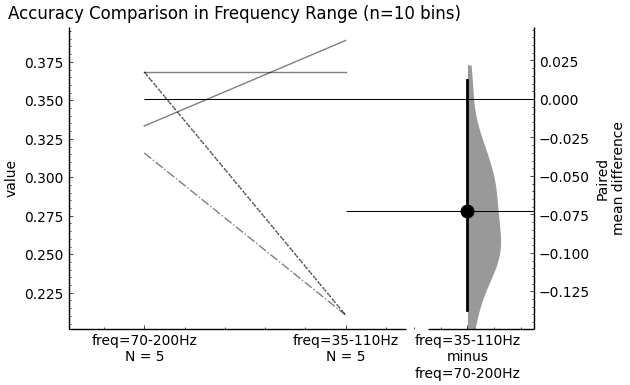

In [39]:
id_col = pd.Series(range(1, n_splits+1))

df = pd.DataFrame({
    "ID": id_col,
    "freq=70-200Hz": stratified_kf_scores_freq_avg["test_accuracy"],
    "freq=35-110Hz": stratified_kf_scores_trimmed["test_accuracy"],
})

my_data = dabest.load(df, idx=("freq=70-200Hz", "freq=35-110Hz"),
                      id_col="ID", paired=True, resamples=100, 
                      random_seed=rng)

fig, ax = plt.subplots(dpi=100)

my_data.mean_diff.plot(ax=ax)
ax.set(title="Accuracy Comparison in Frequency Range (n=10 bins)");

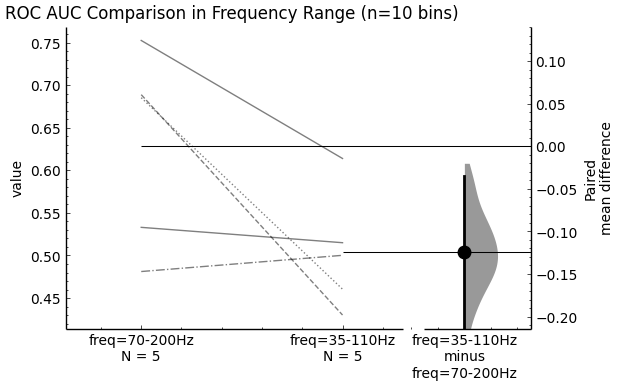

In [40]:
id_col = pd.Series(range(1, n_splits+1))

df = pd.DataFrame({
    "ID": id_col,
    "freq=70-200Hz": stratified_kf_scores_freq_avg["test_roc_auc_ovr"],
    "freq=35-110Hz": stratified_kf_scores_trimmed["test_roc_auc_ovr"],
})

my_data = dabest.load(df, idx=("freq=70-200Hz", "freq=35-110Hz"),
                      id_col="ID", paired=True, resamples=100, 
                      random_seed=rng)

fig, ax = plt.subplots(dpi=100)

my_data.mean_diff.plot(ax=ax)
ax.set(title="ROC AUC Comparison in Frequency Range (n=10 bins)");

## Run on $N \times (C \times F) \times T$ data matrix (70-200 Hz)

In [43]:
nfreqs = 10
freqs = np.logspace(*np.log10([70, 200]), num=nfreqs)
n_cycles = freqs / 2.  # different number of cycle per frequency
power = tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, average=False,
                   return_itc=False, decim=3, n_jobs=1)

hi_gamma = power.data

ntrials, nchs, nfreqs, nsteps = hi_gamma.shape

# structured to have all frequencies of one channel in consecutive rows
freq_data = hi_gamma.reshape(ntrials, nchs*nfreqs, nsteps)

times = np.where((power.times >= -0.5) & (power.times <= 1.0))[0]
freq_data = freq_data[:, :, times]

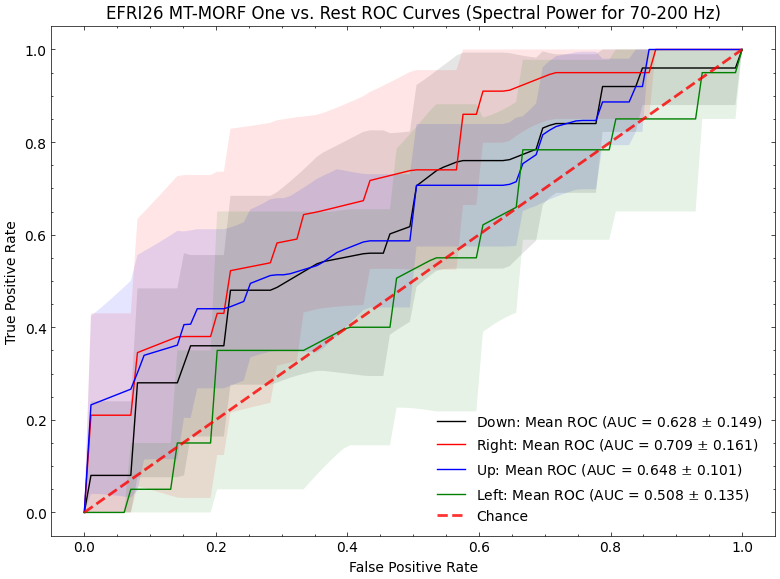

In [44]:
rng = 1

included_trials = np.isin(labels, [0, 1, 2, 3])

# Create X, y data
X = freq_data[included_trials].reshape(np.sum(included_trials), -1)
y = labels[included_trials]

metrics = [
    # 'f1_micro',
    # 'f1_macro',
    'accuracy',
    'roc_auc_ovr',
]

mtsmorf = rerfClassifier(
    projection_matrix="MT-MORF",
    max_features="auto",
    n_jobs=-1,
    random_state=rng,
    image_height=freq_data.shape[1],
    image_width=freq_data.shape[2],
)

stratified_kf_scores_all_freq = cv_fit(mtsmorf, X, y, metrics=metrics, cv=cv, n_jobs=None, return_train_score=True, return_estimator=True)

# Plotting results
fig, ax = plt.subplots(dpi=100, figsize=(8, 6))

plot_roc_multiclass_cv(
    stratified_kf_scores_all_freq["test_predict_proba"],
    X,
    y,
    stratified_kf_scores_all_freq["test_inds"],
    ax=ax,
)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title=f"{subject.upper()} MT-MORF One vs. Rest ROC Curves (Spectral Power for 70-200 Hz)",
)
ax.legend(loc="lower right")
fig.tight_layout();

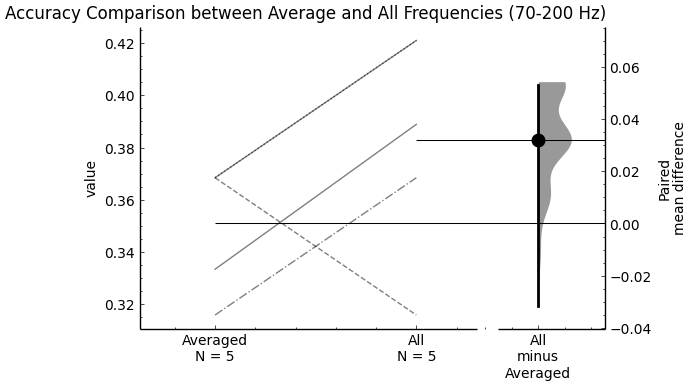

In [45]:
id_col = pd.Series(range(1, n_splits+1))

df = pd.DataFrame({
    "ID": id_col,
    "Averaged": stratified_kf_scores_freq_avg["test_accuracy"],
    "All": stratified_kf_scores_all_freq["test_accuracy"],
})

my_data = dabest.load(df, idx=("Averaged", "All"), 
                      id_col="ID", paired=True, resamples=100, 
                      random_seed=rng)

fig, ax = plt.subplots(dpi=100)

my_data.mean_diff.plot(ax=ax)
ax.set(title="Accuracy Comparison between Average and All Frequencies (70-200 Hz)");

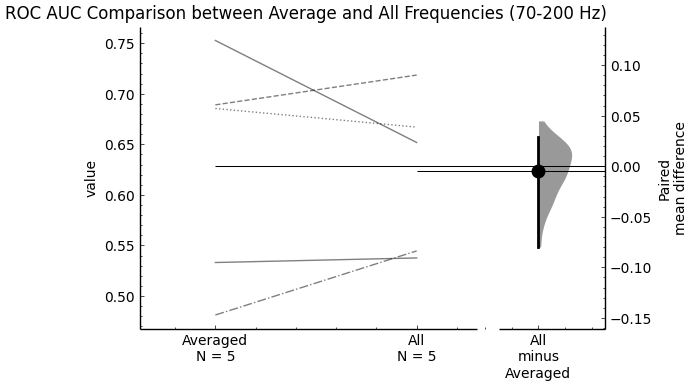

In [46]:
id_col = pd.Series(range(1, n_splits+1))

df = pd.DataFrame({
    "ID": id_col,
    "Averaged": stratified_kf_scores_freq_avg["test_roc_auc_ovr"],
    "All": stratified_kf_scores_all_freq["test_roc_auc_ovr"],
})

my_data = dabest.load(df, idx=("Averaged", "All"), 
                      id_col="ID", paired=True, resamples=100, 
                      random_seed=rng)

fig, ax = plt.subplots(dpi=100)

my_data.mean_diff.plot(ax=ax)
ax.set(title="ROC AUC Comparison between Average and All Frequencies (70-200 Hz)");

## Comparison with other classifiers

In [8]:
nfreqs = 10
freqs = np.logspace(*np.log10([70, 200]), num=nfreqs)
n_cycles = freqs / 2.  # different number of cycle per frequency
power = tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, average=False,
                   return_itc=False, decim=3, n_jobs=1)

hi_gamma = power.data

Not setting metadata


In [14]:
avg_freq_data = np.mean(hi_gamma, axis=2)

# Trim time window
times = np.where((power.times >= -0.5) & (power.times <= 1.0))[0]
avg_freq_data = avg_freq_data[:, :, times]

print(avg_freq_data.shape)

rng = 1

included_trials = np.isin(labels, [0, 1, 2, 3])

# Create X, y data
X = avg_freq_data[included_trials].reshape(np.sum(included_trials), -1)
y = labels[included_trials]

metrics = [
    # 'f1_micro',
    # 'f1_macro',
    'accuracy',
    'roc_auc_ovr',
]

mtsmorf = rerfClassifier(
    projection_matrix="MT-MORF",
    max_features="auto",
    n_jobs=-1,
    random_state=rng,
    image_height=avg_freq_data.shape[1],
    image_width=avg_freq_data.shape[2],
)

srerf = rerfClassifier(
    projection_matrix="S-RerF",
    max_features="auto",
    n_jobs=-1,
    random_state=rng,
    image_height=avg_freq_data.shape[1],
    image_width=avg_freq_data.shape[2],
)

lr = LogisticRegression(random_state=rng)
rf = RandomForestClassifier(random_state=rng)
dummy = DummyClassifier(strategy='most_frequent', random_state=rng)

clf_scores = dict()
clfs = [
    mtsmorf,
    srerf,
    rf,
    lr,
    dummy,
]

n_splits = 5
cv = StratifiedKFold(n_splits=n_splits, shuffle=False)

for clf in tqdm(clfs):
    if clf.__class__.__name__ == "rerfClassifier":
        clf_name = clf.get_params()["projection_matrix"]
    elif clf.__class__.__name__ == "DummyClassifier":
        clf_name = clf.strategy
    else:
        clf_name = clf.__class__.__name__

    clf_scores[clf_name] = cv_fit(
        clf,
        X,
        y,
        cv=cv,
        metrics=metrics,
        n_jobs=None,
        return_train_score=True,
        return_estimator=True,
    )

100%|██████████| 5/5 [02:14<00:00, 26.96s/it]


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


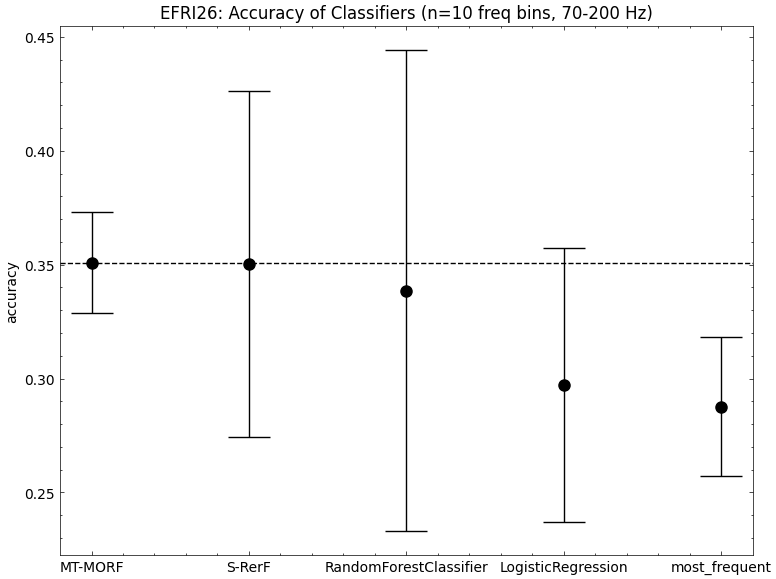

In [15]:
fig, ax = plt.subplots(dpi=100, figsize=(8,6))

accs = np.array([np.mean(scores["test_accuracy"]) for scores in clf_scores.values()])
acc_std = np.array([np.std(scores["test_accuracy"]) for scores in clf_scores.values()])

ax.errorbar(list(clf_scores.keys()), accs, yerr=acc_std, fmt='o', markersize=8, capsize=15)
ax.axhline(np.mean(clf_scores["MT-MORF"]["test_accuracy"]), lw=1, color='k', ls='--')
ax.set(ylabel="accuracy", title=f"{subject.upper()}: Accuracy of Classifiers (n=10 freq bins, 70-200 Hz)")
fig.tight_layout();

## Subset channels by anat

In [18]:
bids_root = Path("/workspaces/research/mnt/data/efri")

# subject identifiers
subject = "efri26"
session = "efri"
task = "move"
acquisition = "seeg"
run = "01"
kind = "ieeg"

bids_path = BIDSPath(subject=subject, session=session, task=task,
                    acquisition=acquisition, run=run, suffix=kind, extension=".tsv", root=bids_root)
bids_path.update(suffix="channels")
bads = _get_bad_chs(bids_path)

tmp = _from_tsv(bids_path)
tmp = [
    (name, anat) 
    for (name, anat) in zip(tmp["name"], tmp["anat"]) 
    if name not in bads
]

channels = pd.DataFrame(tmp, columns=["name", "anat"])
sorted_channels = channels.sort_values(["anat"])
sorted_channels.head()


name             anat
107  REF2               CZ
106  REF1               FZ
108     E               PZ
30   Y'12  angular gyrus L
31   Y'11  angular gyrus L

In [21]:
sorted_channels[sorted_channels["anat"].str.contains("insular cortex|central sulcus")]

name                          anat
91  R'1   insular cortex (anterior) L
90  R'2   insular cortex (anterior) L
82  T'2  insular cortex (posterior) L
76  S'1  insular cortex (posterior) L
75  S'2  insular cortex (posterior) L
83  T'1  insular cortex (posterior) L
84  R'9           precentral sulcus L
85  R'8           precentral sulcus L
86  R'7           precentral sulcus L

In [33]:
anat = sorted_channels["anat"].str.contains("insular cortex|central sulcus")
picks = list(sorted_channels[anat]["name"])
epochs_anat = epochs.pick_channels(picks)

nfreqs = 10
freqs = np.logspace(*np.log10([70, 200]), num=nfreqs)
n_cycles = freqs / 2.  # different number of cycle per frequency
power = tfr_morlet(epochs_anat, freqs=freqs, n_cycles=n_cycles, average=False,
                   return_itc=False, decim=3, n_jobs=1)

hi_gamma = power.data

Not setting metadata


In [34]:
avg_freq_data = np.mean(hi_gamma, axis=2)

# Trim time window
times = np.where((power.times >= -0.5) & (power.times <= 1.0))[0]
avg_freq_data = avg_freq_data[:, :, times]

print(avg_freq_data.shape)

rng = 1

included_trials = np.isin(labels, [0, 1, 2, 3])

# Create X, y data
X = avg_freq_data[included_trials].reshape(np.sum(included_trials), -1)
y = labels[included_trials]

metrics = [
    # 'f1_micro',
    # 'f1_macro',
    'accuracy',
    'roc_auc_ovr',
]

mtsmorf = rerfClassifier(
    projection_matrix="MT-MORF",
    max_features="auto",
    n_jobs=-1,
    random_state=rng,
    image_height=avg_freq_data.shape[1],
    image_width=avg_freq_data.shape[2],
)

srerf = rerfClassifier(
    projection_matrix="S-RerF",
    max_features="auto",
    n_jobs=-1,
    random_state=rng,
    image_height=avg_freq_data.shape[1],
    image_width=avg_freq_data.shape[2],
)

lr = LogisticRegression(random_state=rng)
rf = RandomForestClassifier(random_state=rng)
dummy = DummyClassifier(strategy='most_frequent', random_state=rng)

clf_scores = dict()
clfs = [
    mtsmorf,
    srerf,
    rf,
    lr,
    dummy,
]

n_splits = 5
cv = StratifiedKFold(n_splits=n_splits, shuffle=False)

for clf in tqdm(clfs):
    if clf.__class__.__name__ == "rerfClassifier":
        clf_name = clf.get_params()["projection_matrix"]
    elif clf.__class__.__name__ == "DummyClassifier":
        clf_name = clf.strategy
    else:
        clf_name = clf.__class__.__name__

    clf_scores[clf_name] = cv_fit(
        clf,
        X,
        y,
        cv=cv,
        metrics=metrics,
        n_jobs=None,
        return_train_score=True,
        return_estimator=True,
    )

100%|██████████| 5/5 [00:29<00:00,  5.82s/it]


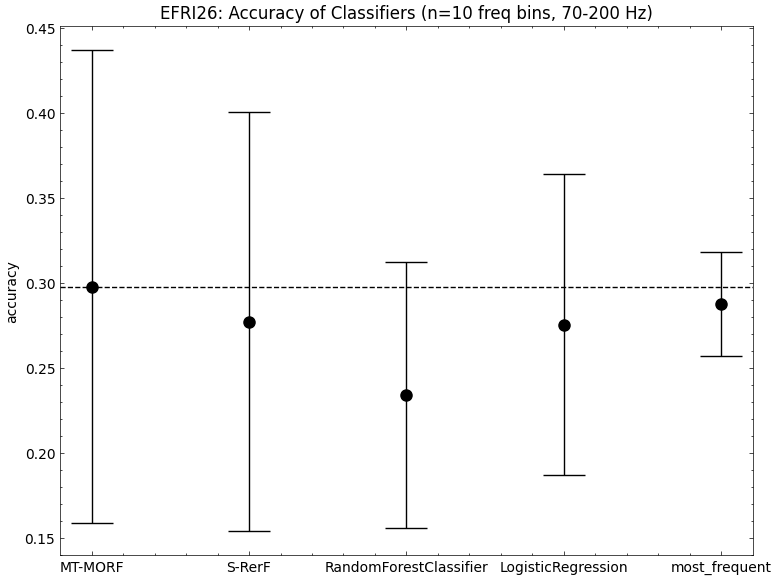

In [35]:
fig, ax = plt.subplots(dpi=100, figsize=(8,6))

accs = np.array([np.mean(scores["test_accuracy"]) for scores in clf_scores.values()])
acc_std = np.array([np.std(scores["test_accuracy"]) for scores in clf_scores.values()])

ax.errorbar(list(clf_scores.keys()), accs, yerr=acc_std, fmt='o', markersize=8, capsize=15)
ax.axhline(np.mean(clf_scores["MT-MORF"]["test_accuracy"]), lw=1, color='k', ls='--')
ax.set(ylabel="accuracy", title=f"{subject.upper()}: Accuracy of Classifiers (n=10 freq bins, 70-200 Hz)")
fig.tight_layout();

In [36]:
# Trim time window
hi_gamma = power.data

ntrials, nchs, nfreqs, nsteps = hi_gamma.shape

# structured to have all frequencies of one channel in consecutive rows
freq_data = hi_gamma.reshape(ntrials, nchs*nfreqs, nsteps)

times = np.where((power.times >= -0.5) & (power.times <= 1.0))[0]
freq_data = freq_data[:, :, times]

print(freq_data.shape)

rng = 1

included_trials = np.isin(labels, [0, 1, 2, 3])

# Create X, y data
X = freq_data[included_trials].reshape(np.sum(included_trials), -1)
y = labels[included_trials]

metrics = [
    # 'f1_micro',
    # 'f1_macro',
    'accuracy',
    'roc_auc_ovr',
]

mtsmorf = rerfClassifier(
    projection_matrix="MT-MORF",
    max_features="auto",
    n_jobs=-1,
    random_state=rng,
    image_height=freq_data.shape[1],
    image_width=freq_data.shape[2],
)

srerf = rerfClassifier(
    projection_matrix="S-RerF",
    max_features="auto",
    n_jobs=-1,
    random_state=rng,
    image_height=freq_data.shape[1],
    image_width=freq_data.shape[2],
)

lr = LogisticRegression(random_state=rng)
rf = RandomForestClassifier(random_state=rng)
dummy = DummyClassifier(strategy='most_frequent', random_state=rng)

clf_scores = dict()
clfs = [
    mtsmorf,
    srerf,
    rf,
    lr,
    dummy,
]

n_splits = 5
cv = StratifiedKFold(n_splits=n_splits, shuffle=False)

for clf in tqdm(clfs):
    if clf.__class__.__name__ == "rerfClassifier":
        clf_name = clf.get_params()["projection_matrix"]
    elif clf.__class__.__name__ == "DummyClassifier":
        clf_name = clf.strategy
    else:
        clf_name = clf.__class__.__name__

    clf_scores[clf_name] = cv_fit(
        clf,
        X,
        y,
        cv=cv,
        metrics=metrics,
        n_jobs=None,
        return_train_score=True,
        return_estimator=True,
    )

100%|██████████| 5/5 [02:27<00:00, 29.47s/it]


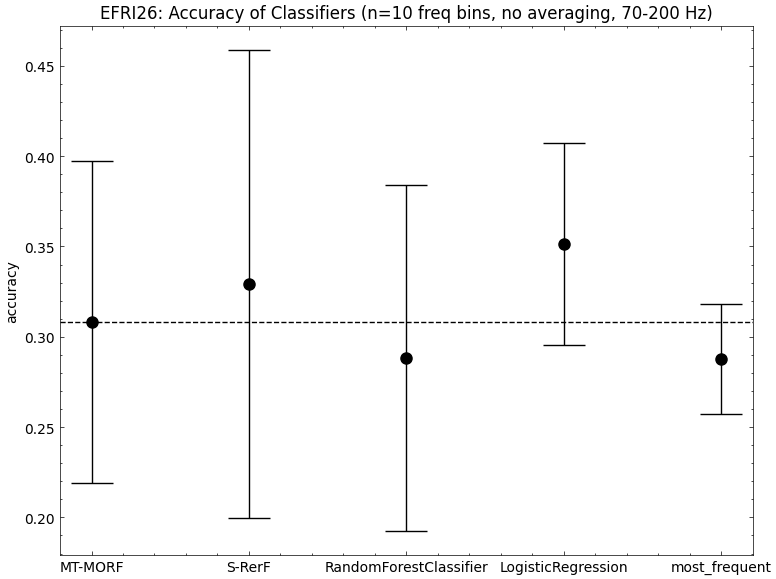

In [38]:
fig, ax = plt.subplots(dpi=100, figsize=(8,6))

accs = np.array([np.mean(scores["test_accuracy"]) for scores in clf_scores.values()])
acc_std = np.array([np.std(scores["test_accuracy"]) for scores in clf_scores.values()])

ax.errorbar(list(clf_scores.keys()), accs, yerr=acc_std, fmt='o', markersize=8, capsize=15)
ax.axhline(np.mean(clf_scores["MT-MORF"]["test_accuracy"]), lw=1, color='k', ls='--')
ax.set(ylabel="accuracy", title=f"{subject.upper()}: Accuracy of Classifiers (n=10 freq bins, no averaging, 70-200 Hz)")
fig.tight_layout();